# Mini-projet géophysique : interpolation de données manquantes

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. C'est une colonne dans les représentation graphiques plus bas.

En pratique, il arrive que certains capteurs soient défaillants ou encore qu'ils ne soient pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse que les **signaux sont essentiellement linéraires** dans les enregistrements (i.e. on peut localement déduire la trace suivante à partir de la trace précédente, avec un décalage en temps qui est proportionnel à la distance entre les traces). L'approximation linéaire est explicitée plus bas.

*Notions abordées* : 
* Lien entre la représentation avant et après transformée de Fourier 2d
* Effets de bords

Pour cela, nous considérons l'approche suivante :
* Transformée de Fourier 2d
* Identification des événements principaux
* Définition d'un masque
* Reconstitution des traces manquantes par transformee de Fourier inverse

L'approche est appliquée sur 3 jeux de données : 
* Donnees simples (un seul événement) : `gpanel1.npy`
* Donnees complexes (4 événements) : `gpanel2.npy`
* Sur vos propres données.

*Attentes* :
* Regard critique sur les résulats obtenus
* Inventivité (pour la troisième application)

*Consignes* :
* **Très important**: pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles

In [93]:
# Modules
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd

**Lecture des données**

In [2]:
# Labelsize (display)
labelsize   = 14
    
# Load the simple input data
# Input data (with missing traces)
gpanel1 = np.load('gpanel1.npy')
# Dense data (with all traces, only for comparison)
panel_dense1 = np.load('panel_dense1.npy')
nt, nx = gpanel1.shape
print("Taille des données :",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Taille des données : 400 30


**Affichage des données**

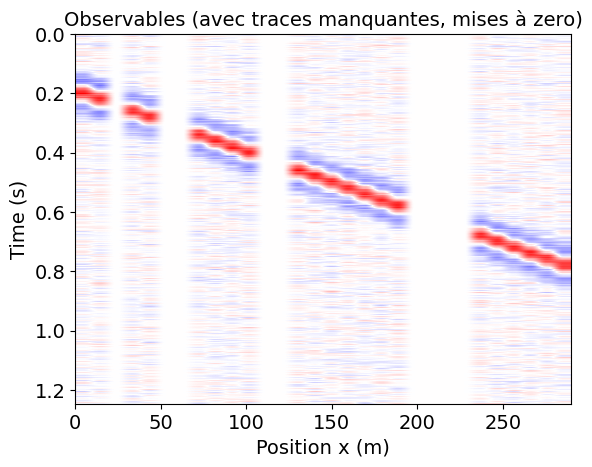

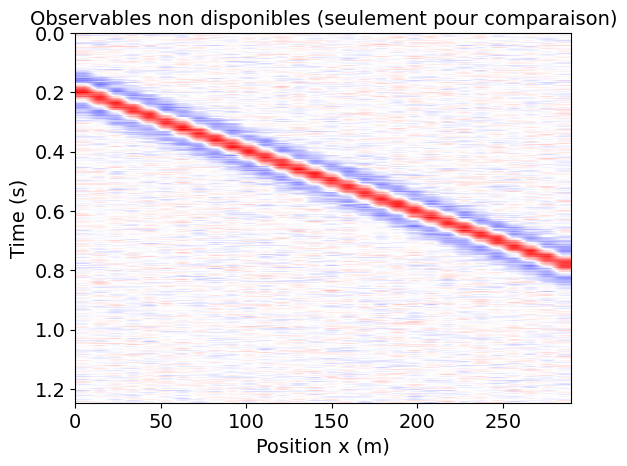

In [3]:
# Display of the input data
vmax    = np.max(np.abs(gpanel1))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Partie 1. Données simples (7 points)

## Approche théorique

On peut supposer que $$u(t,x) = S\big(t-t_0-p_0(x-x_0)\big)$$

C'est l'approximation linéaire mentionnée plus haut,
avec $S(t)$ une ondelette source, $t_0$ le temps à la position $x=x_0$, et la pente_tab_tab_tab $p_0$ en s/m associée à l'événement. Ici : $t_0=0.2$ s (pour $x_0 = 0$ m) et $p_0=0.002$ s/m.

Tracer la droite définie par $t_0$ et $p_0$ sur les observables (`gpanel1`) pour vérifier qu'elle se superpose bien à l'événement principal.


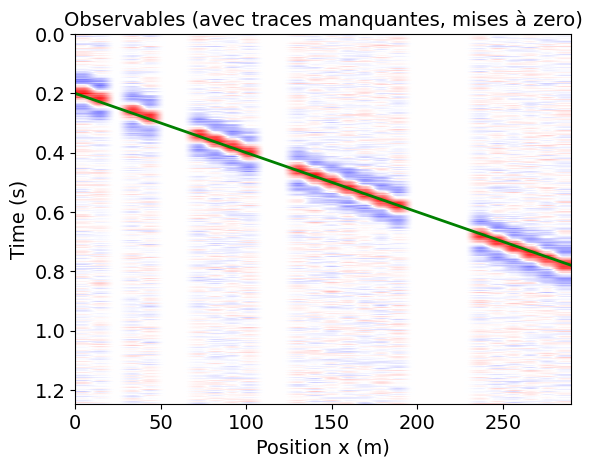

In [4]:
vmax = np.max(np.abs(gpanel1))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel1,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

#Tracer la droite 
t0 = 0.2
x0 = 0 
p0 = 0.002
x_range = np.array([ax[0], ax[-1]])  # valeurs x pour tracer la droite
t_line = t0 + p0 * (x_range - x0)  

plt.plot(x_range, t_line, color='green', linewidth=2)
plt.show()

On observe que la droite tracée en vert et le signal enregistré se superposent bien. 


Calculer l'expression de la transformée de Fourier 2d $\hat{u}(\omega,k)$ de $u(t,x)$ à partir de la transformée de Fourier 1d $\hat{S}(\omega)$ de $S(t)$. En déduire une expression simple de $|\hat{u}|$ en lien avec $|\hat{S}(\omega)|$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir un événement linéaire dans le domaine de Fourier. Pourquoi l'événement passe-t-il par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre la pente_tab dans le domaine de Fourier $(\omega,k)$ et la pente dans le domaine $(t,x)$.

Pour simplifier l'expression, on peut utiliser

$$\int dx e^{-i k x} = \delta(k)$$

avec $\delta$ la distribution de Dirac.

On utilise la définition de la transformée de Fourier, $$ \^u(\omega,k)=\int_{x=-\infty}^{x=+\infty} \int_{t=-\infty}^{t=+\infty} e^{-i(\omega t + k x)} u(t,x) dt dx = \int_{x=-\infty}^{x=+\infty} \int_{t=-\infty}^{t=+\infty} e^{-i(\omega t + k x)} S(t-t_{0}-p_{0}(x-x_{0})) dt dx $$ 
Soit  $$ \^u(\omega,k)= \int_{x=-\infty}^{x=+\infty}   e^{-ikx} \int_{t=-\infty}^{t=+\infty} e^{-i( \omega t)} S(t-t_{0}-p_{0}(x-x_{0})) dt dx $$. 
On pose le changement de variable, $$ v = t-t_{0}-p_{0}(x-x_{0}) $$. 
Alors, d'après le théorème de Fubini, $$ \^u(\omega,k) =  \int_{x=-\infty}^{x=+\infty}   e^{-ikx}  dx \int_{v=-\infty}^{v=+\infty} e^{-i\omega (v +t_{0} + p_{0}(x-x_{0})) }  S(v) dv $$. On a $$ \^u(\omega,k) = e^{-i\omega (t_{0}-p_{0} x_{0})} \int_{x=-\infty}^{x=+\infty}   e^{-i(k+\omega p_{0}) x} dx \int_{v=-\infty}^{v=+\infty} S(v) e^{-i\omega v}) $$. 

On en déduit alors que $$  \^u(\omega,k) = e^{-i \omega(t_{0}-p_{0}x_{0})}  \delta(k+\omega p_{0}) \^S(\omega) $$ et que $ |\^u(\omega,k) | = | \delta(k+\omega p_{0})  \^S(\omega)| $.

Alors, $ \^u(\omega=0,k=0)= \^S(0) $ et puisque $\^S(0)=\int_{t=-\infty}^{t=+\infty} S(t) dt $ l'événement passe par (0,0) dans le domaine de Fourier car il s'agit de l'intégrale du signal en un point. D'après l'expression obtenue par le calcul, la transformée de Fourier est non-nulle si $ k+\omega p_{0}=0$ donc on a  $ p_{0} = \frac{-k}{\omega}$.

## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Faire le lien entre l'événement dans l'espace $(t,x)$ et celui dans l'espace de Fourier. Comme pour le domaine $(t,x)$, tracer la droite correspondante dans le domaine $(\omega,k)$. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hésitez pas à zoomer autour de la position centrale $(0,0)$ dans le domaine de Fourier pour une meilleure représentation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


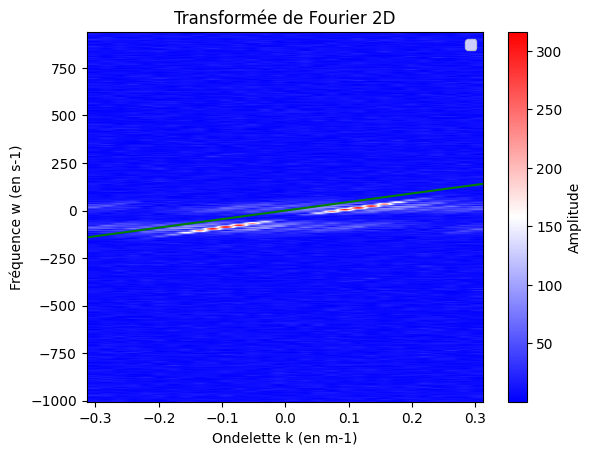

In [5]:
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
# fftshift est utilisé pour recentrer les fréquences à zéro

#renormalisation de la fréquence et du vecteur d'onde
n = gpanel1.shape[0]
m = gpanel1.shape[1]
dt = np.abs(at[1] - at[0])
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (m * dt)
dk = 2 * np.pi / (n * dx)
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
w = np.fft.fftshift(np.fft.fftfreq(m, dt)) * 2 * np.pi
k = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

# Tracer la transformée de Fourier 2D
plt.imshow(np.abs(tf), extent=[k[0],k[-1],w[0],w[-1]], aspect='auto')
plt.title('Transformée de Fourier 2D')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')

plt.ylim((-250,250)) #afin d'améliorer l'affichage 
plt.colorbar(label='Amplitude')
plt.xlim(k[0],k[-1]) # Zoom (assez violent) pour mieux voir le signal de l'événement 
plt.ylim(w[0],w[-1])
pente_droite=450
plt.plot(k,k*pente_droite,c='green')
plt.legend()
plt.show()

On observe que le lien entre les ondelettes $k$ et les pulsations $\omega$ est tel que $ \omega =\frac{k}{0.002} $. 

## Définition d'un masque dans le domaine de Fourier 2d
On note $\omega$ la fréquence angulaire et $k$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(\omega,k)=(0,0)$, faire des sommations selon différentes pente_tabs (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente_tab. On s'attend à ce que une valeur ressorte. Calculer une fonction qui sélectionne automatiquement cette valeur et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de la valeur principale et 0 en dehors.

On trouve que la pente qui maximise la somme le long de la droite est -444.44444444444446


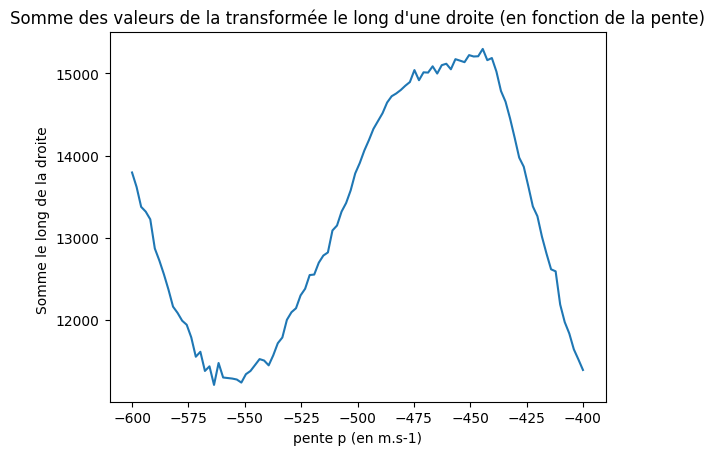

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


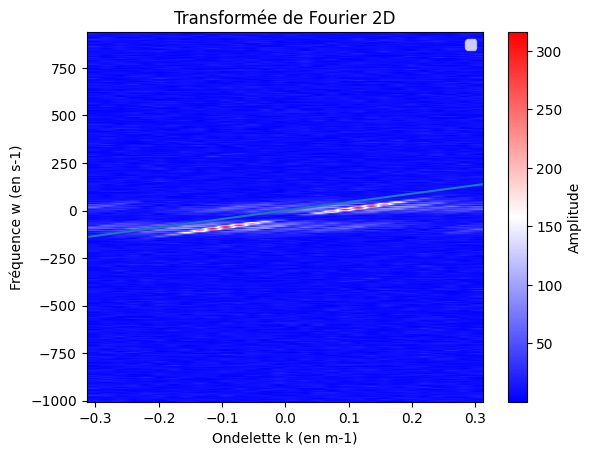

In [6]:
import numpy as np
import matplotlib.pyplot as plt

n = gpanel1.shape[0]
m = gpanel1.shape[1]
dt = np.abs(at[1] - at[0])
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (m * dt)
dk = 2 * np.pi / (n * dx)
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
w = np.fft.fftshift(np.fft.fftfreq(m, dt)) * 2 * np.pi
k = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

def contin(tf,k_,w_):
    return tf[int((w_-min(w))/(max(w)-min(w))*tf.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])] # On récupère la valeur de la transformée de Fourier pour (k,w): il faut calculer les indices 

def pente_():
    pente=np.linspace(-600,-400,100) # On choisit une liste assez large de pentes possibles 
    somme_pente=[]
    for p in pente:
        w_selec=[(k_,k_*p) for k_ in k[1:-1] if (k_*p > min(w)) and (k_*p < max(w))] # On génère des couples (k,pente*k), en prenant garde à ce que l'ordonnée reste dans l'intervalle admissible
        s=0
        for i in range(len(w_selec)):
            s+=np.abs(contin(tf,w_selec[i][0],w_selec[i][1])) # On fait la somme le long de la droite donnée 
        somme_pente.append(s)
    return pente,somme_pente,pente[np.argmax(somme_pente)]

print("On trouve que la pente qui maximise la somme le long de la droite est",pente_()[2])

plt.title("Somme des valeurs de la transformée le long d'une droite (en fonction de la pente)")
plt.xlabel("pente p (en m.s-1)")
plt.ylabel("Somme le long de la droite ")
plt.plot(pente_()[0],pente_()[1])
plt.show()
# Tracer la transformée de Fourier 2D
plt.figure()
plt.imshow(np.abs(tf), extent=[k[0], k[-1], w[0],w[-1]], aspect='auto')
plt.title('Transformée de Fourier 2D')
plt.plot(k,444*k)
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()


## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats. Si nécessaire, revenir à la question précédente pour changer la forme du masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


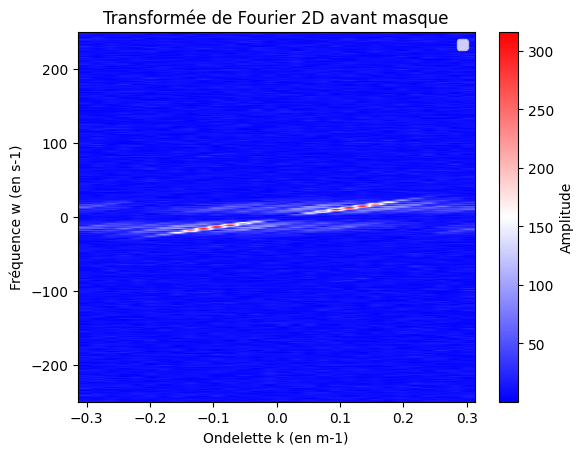

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


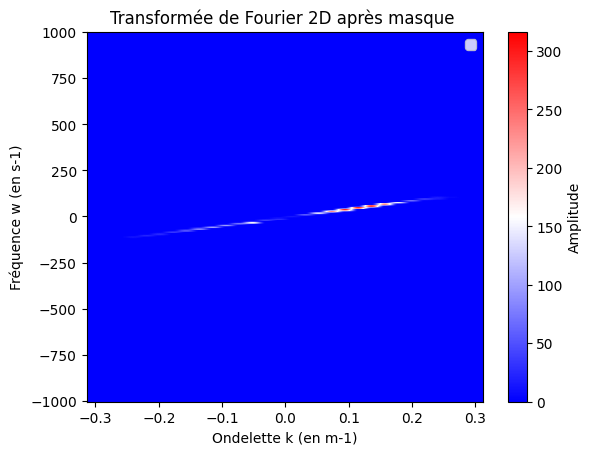

In [27]:
n = gpanel1.shape[0]
dt = np.abs(at[1] - at[0])
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (n * dt)
dk = 2 * np.pi / (n * dx)
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
w = np.fft.fftshift(np.fft.fftfreq(n, dt)) * 2 * np.pi
k = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

plt.figure()
plt.imshow(np.abs(tf), extent=[k[0], k[-1], -250, 250], aspect='auto')
plt.title('Transformée de Fourier 2D avant masque')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()


p_=-444
tf_m=np.zeros((tf.shape[0],tf.shape[1]),dtype=int)
mask=np.zeros((tf.shape[0],tf.shape[1]),dtype=int) # On sélectionne lelong de la pente identifiée 
for k_ in np.linspace(-0.25,0.25,100):
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1
tf_m=tf*mask

# Tracer la transformée de Fourier 2D
plt.figure()
plt.imshow(np.abs(tf_m), extent=[k[0], k[-1], w[0], w[-1]], aspect='auto')
plt.title('Transformée de Fourier 2D après masque ')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

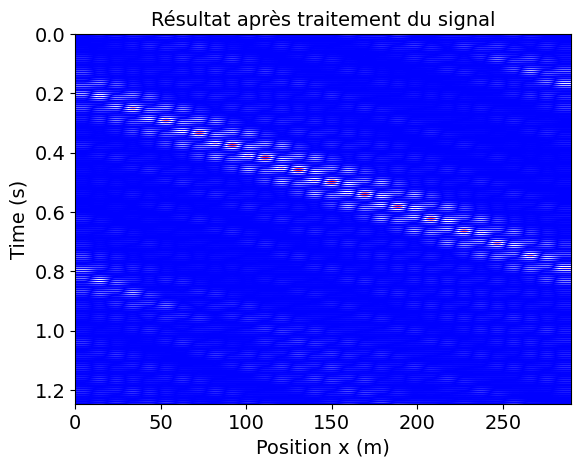

In [28]:
vmax=np.max(np.real(np.fft.ifft2(tf_m)))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([0,vmax])
plt.set_cmap('bwr')

Le signal est bien prolongé mais on observe néanmoins la présence d'artefacts lors du calcul de la transformée de Fourier inverse. Cela s'explique en partie par le fait que l'application d'un masque "en créneau" à la transformée de Fourier conduit à l'apparition de ce phénomène indésirable. On va donc utiliser un fenêtrage autour de la droite selectionnée dans l'esoace de Fourier afin de minimiser cet effet indésirable. Ici, le masque ne sera plus composé de 0 et de 1 seulement mais de 0, de 1 et de $ r^{-n}$ où $ n \in \mathbb{N} , r>1 $.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


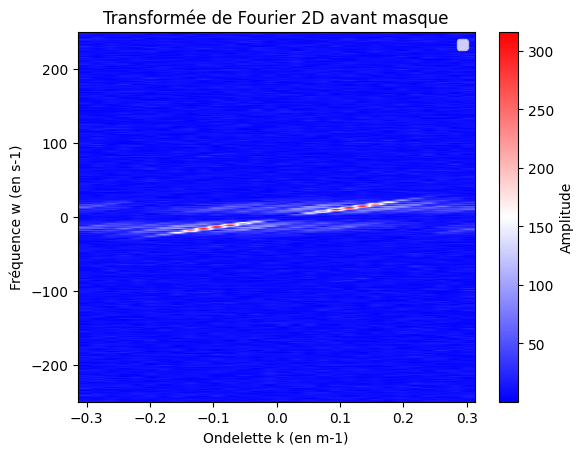

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


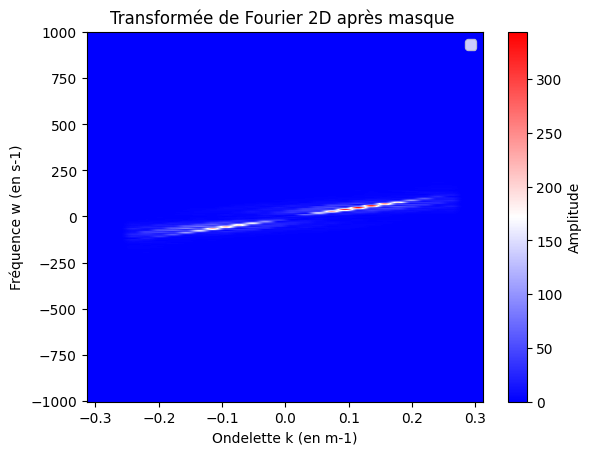

In [20]:
""" La valeur maximale de la somme est atteinte pour une pente de p=200 s.m-1. On applique donc le filtre avec cette valeur de pente."""

n = gpanel1.shape[0]
dt = np.abs(at[1] - at[0])
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (n * dt)
dk = 2 * np.pi / (n * dx)
tf = np.fft.fftshift(np.fft.fft2(gpanel1))
w = np.fft.fftshift(np.fft.fftfreq(n, dt)) * 2 * np.pi
k = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

plt.figure()
plt.imshow(np.abs(tf), extent=[k[0], k[-1], -250, 250], aspect='auto')
plt.title('Transformée de Fourier 2D avant masque')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()


p_=-444
tf_m=tf.copy()

# On crée le masque adapté, en mettant des 1 qu'au niveau des indices qui correspondent aux points le long de la droite. 
"""
mask=np.zeros((tf.shape[0],tf.shape[1]),dtype=int)
for k_ in np.linspace(-0.25,0.25,100):
    mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1
    if int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0]) < tf.shape[0]-2:
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])+1,int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1
    if int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])-1>0:
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])-1,int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1
 """   

mask=np.zeros((tf.shape[0],tf.shape[1]),dtype=float)
for k_ in np.linspace(-0.25,0.25,100):
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1.2        
        for di in range(2,min(tf.shape[0],tf.shape[1])): # On applique un masque "en puissance de 2" selon la diagonale
            if int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0]) < tf.shape[0]-di:
                mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])+(di-1),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1/((1.15)**(di-1))
            if int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])-1>0:
                mask[int((k_*p_-min(w))/(max(w)-min(w))*tf.shape[0])-(di-1),int((k_-min(k))/(max(k)-min(k))*tf.shape[1])]=1/((1.15)**(di-1))

tf_m=tf*mask
# Tracer la transformée de Fourier 2D
plt.figure()
plt.imshow(np.abs(tf_m), extent=[k[0], k[-1], w[0], w[-1]], aspect='auto')
plt.title('Transformée de Fourier 2D après masque ')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

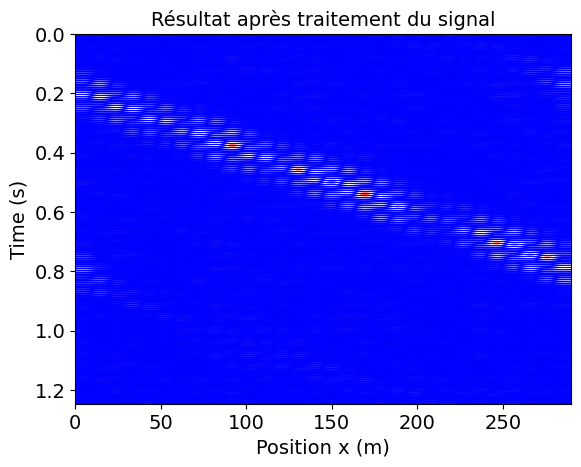

In [21]:
vmax=np.max(np.real(np.fft.ifft2(tf_m)))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([0,vmax])
plt.set_cmap('bwr')

On constate que le traitement appliqué permet de faire disparaître les zones manquantes lors de l'acquisition du signal. De plus, on a réussi à limiter l'apparition de nouveaux signaux parasites.

# Partie 2. Données complexes (7 points)

Recommencer la même procédure (interpolation des données) sur les données plus complexes (`gpanel2.npy`). Analyser les similitudes et différences, et en particulier les difficultés rencontrées.

Les pente sont : 
$p_0 = 0.006$, $p_1 = 0.002$, $p_2 = -0.004$ et $p_3 = -0.0005$ en s/m 
et les temps associes (pour $x_0=0$ m) : $t_0 = 0.1$, $t_1 = 0.3$, $t_2 = 1.1$ et $t_3 = 1.8$ en s.


In [31]:
# Load the input data
# Input data (with missing traces)
gpanel2 = np.load('gpanel2.npy')
# Dense data (with all traces, only for comparison)
panel_dense2 = np.load('panel_dense2.npy')
nt, nx = gpanel2.shape
print("Taille des données :",nt,nx)

Taille des données : 400 30


**Affichage des données**

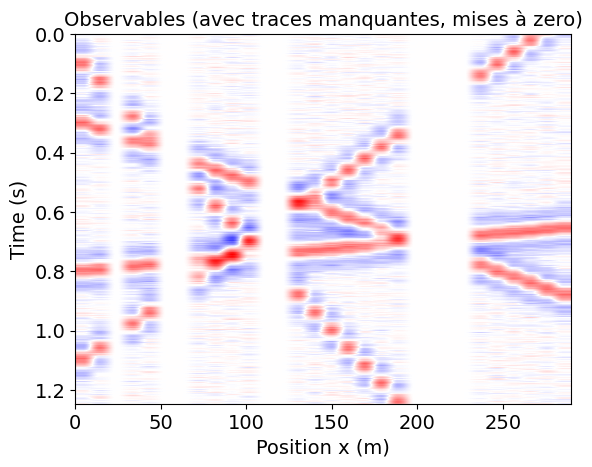

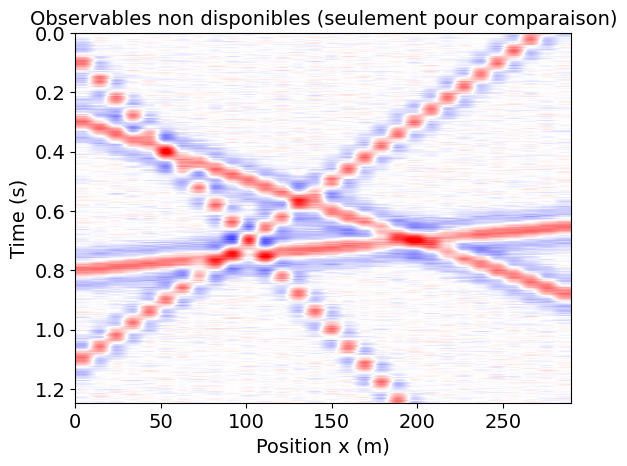

In [32]:
# Display of the input data
vmax    = np.max(np.abs(gpanel2))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


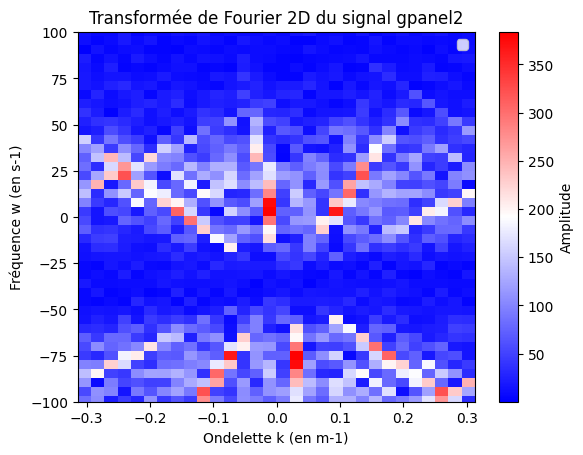

In [34]:
# Calcul de la transformée de Fourier 2D
tf2 = np.fft.fftshift(np.fft.fft2(gpanel2))
# fftshift est utilisé pour recentrer les fréquences à zéro

# Création des axes de fréquence (w) et d'onde (k)
n = gpanel2.shape[0]
m = gpanel2.shape[1]
dt = np.abs(at[1] - at[0])
dx = np.abs(ax[1] - ax[0])
dw = 2 * np.pi / (m * dt)
dk = 2 * np.pi / (n * dx)
w2 = np.fft.fftshift(np.fft.fftfreq(m, dt)) * 2 * np.pi
k2 = np.fft.fftshift(np.fft.fftfreq(n, dx)) * 2 * np.pi

# Tracer la transformée de Fourier 2D
plt.imshow(np.abs(tf2), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

On se contente d'abord de seulement transposer la méthode de la partie 1. La difficulté principale est qu'il faut créer un masque qui délimite une zone contenant les points appartenant à une des 4 droites.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


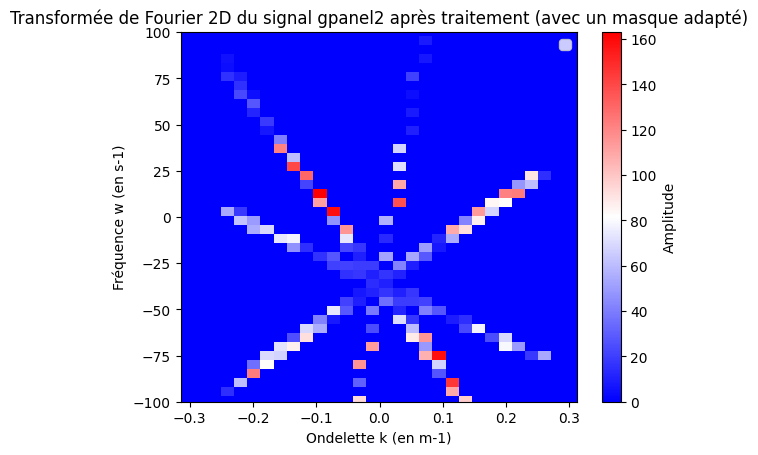

In [35]:

tf2_m=np.zeros((tf3.shape[0],tf3.shape[1]),dtype='complex')
mask=np.zeros((tf3.shape[0],tf3.shape[1]),dtype=float)

for p_ in [ 1/0.002, 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf3.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf3.shape[1])]=1
        
tf3_m=tf3*mask

# Tracer la transformée de Fourier 2D
plt.imshow(np.abs(tf3_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

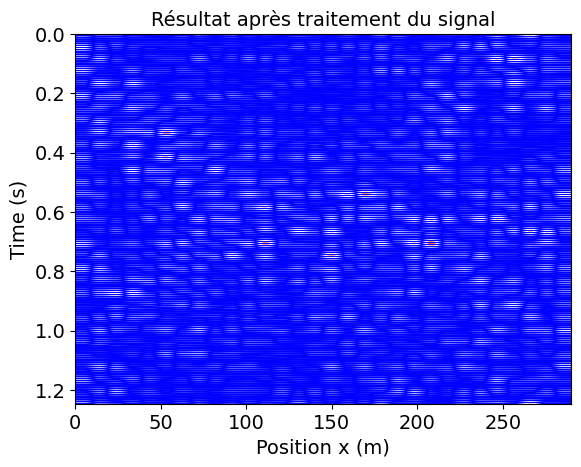

In [36]:
vmax=np.max(np.real(np.fft.ifft2(tf3_m)))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf2_m)),extent=[ax[0],ax[-1],at[-1],at[0]], aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([0,vmax])
plt.set_cmap('bwr')

Ici, on observe que le signal obtenu n'a rien à voir avec le signal initial. On applique alors un masque avec une fenêtre, autour de cahque droite, comme dans le cas du premier exemple.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


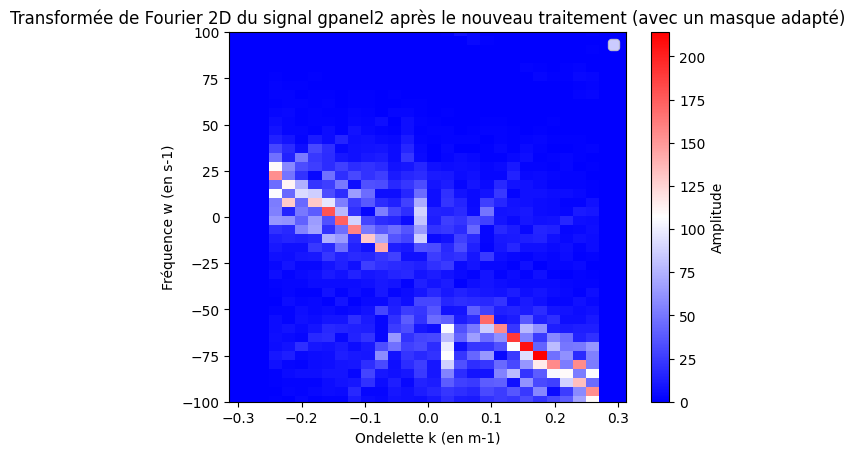

In [41]:
mask=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=float)
tf2_m=np.zeros((tf2.shape[0],tf2.shape[1]),dtype='complex')
for p_ in [ 1/0.002, 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        mask[int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf2.shape[1])]=1
        for di in range(2,min(tf2.shape[0],tf2.shape[1])): # On applique un masque "en puissance de 2" selon la diagonale
            if int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0]) < tf2.shape[0]-di:
                mask[int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0])+(di-1),int((k_-min(k))/(max(k)-min(k))*tf2.shape[1])]=1/((1.2)**(di-1))
            if int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0])-(di-1)>0:
                mask[int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0])-(di-1),int((k_-min(k))/(max(k)-min(k))*tf2.shape[1])]=1/((1.2)**(di-1))    

tf2_m=tf2*mask

plt.imshow(np.abs(tf2_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après le nouveau traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

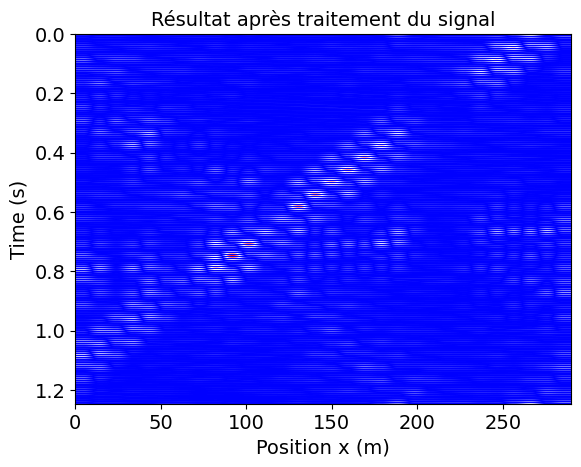

In [42]:
vmax=np.max(np.real(np.fft.ifft2(tf2_m)))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf2_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([0,vmax])
plt.set_cmap('bwr')

On constate cependant ici que le signal obtenu n'est pas conforme aux mesures. En effet, l'application de la fenêtre autour du masque conduit à atténuer successivement les valeurs calculées relativement aux autres droites. On n'a, en fait, appliqué la transformée de Fourier fenêtrée en dimension 2 pour une seule droite dans l'espace de Fourier. On va alors appliquer un nouveau masque, mais la fenêtre sera cette fois-ci calculée grâce à la distance euclidienne, dans l'espace de Fourier, du point considéré par rapport à l'ensemble constitué par les 4 droites. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


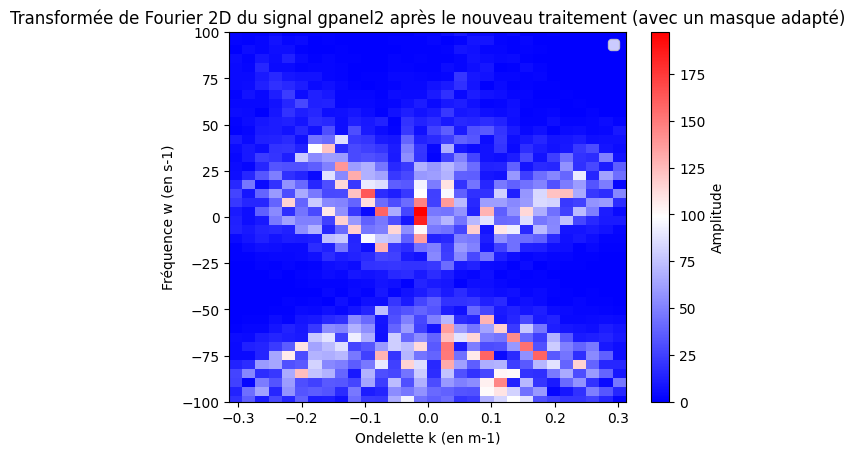

In [75]:
mask=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=complex)
tf2_m=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=complex)

masque=[]
for p_ in [ 1/0.002 , 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        masque.append([int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf2.shape[1])]) # On identifie l'espace autour des 4 droites 

distance_tab=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=float)
def distance_au_masque(abscisse,ordonnee): # algorithme NAIF pour déterminer le projecteur 
    dis=float('inf')
    for point in masque: 
        if ((abscisse-point[0])**2+(ordonnee-point[1])**2)<dis**2:
            dis=np.sqrt(((abscisse-point[0])**2+(ordonnee-point[1])**2))
    distance_tab[i][j]=dis
    return dis 

for i in range(tf2.shape[0]):
    for j in range(tf2.shape[1]):
        mask[i][j]=1/((1.6)**(distance_au_masque(i,j))) # On calcule la fenêtre autour des 4 droites 

tf2_m=tf2*mask

plt.imshow(np.abs(tf2_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après le nouveau traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

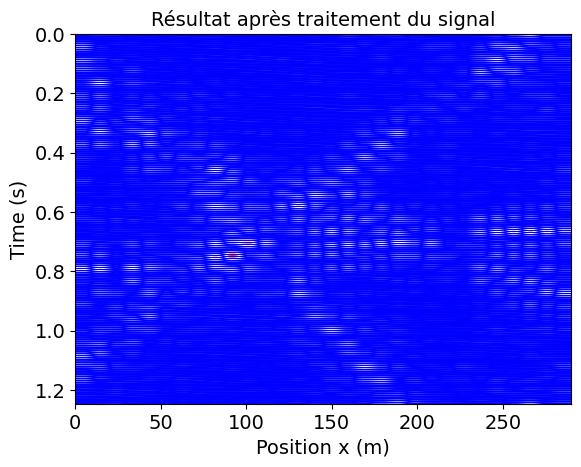

In [76]:
vmax=np.max(np.real(np.fft.ifft2(tf2_m)))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf2_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([0,vmax])
plt.set_cmap('bwr')

Une difficulté que l'on rencontre ici est de choisir la valeur du $r$ utilisé dans la fenêtre du masque pour calculer les coefficients en $ r^{-n}, n \in \mathbb{N}$. On sait que $ r> 1 $ mais on constate que plus r est grand, plus les blancs disparaissent mais que cela favorise également l'apparition d'artefacts. A l'inverse, choisir $r$ trop proche de 1 amène à obtenir un signal qui se rapproche trop du signal original, et qui est donc lacunaire. 

On modifie une dernière fois le traitement appliqué au signal pour diviser par un facteur $ r^{-n'}$ où $ n' > n $, les points qui se situent à égale distance de plusieurs points du masque. Le but est de limiter le bruit issu des points de l'espace de Fourier qui se situent entre les droites et dont la valeur de la transformée n'a pas été suffisamment diminuée par le traitement actuel. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


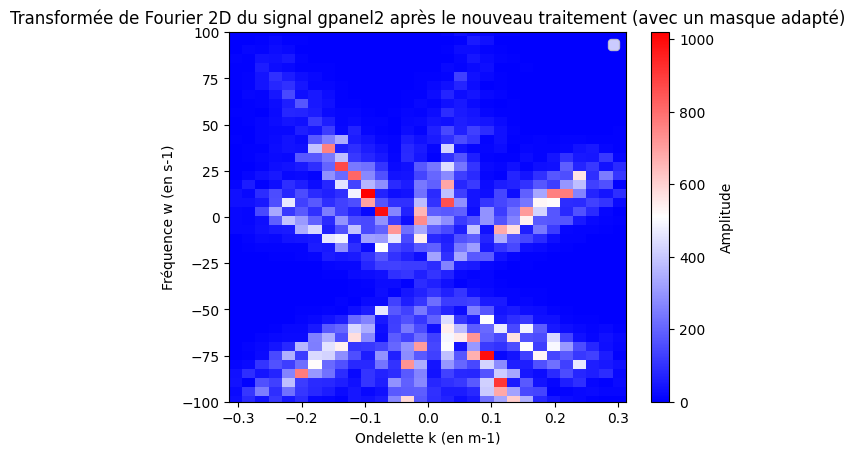

In [90]:
mask=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=complex)
tf2_m=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=complex)

masque=[]
for p_ in [ 1/0.002 , 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        masque.append([int((k_*p_-min(w))/(max(w)-min(w))*tf2.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf2.shape[1])]) # On identifie l'espace autour des 4 droites 

#distance_tab=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=float)
def distance_au_masque(abscisse,ordonnee): # algorithme NAIF pour déterminer le projecteur 
    dis=float('inf')
    for point in masque: #On itère sur tous les points du masque
        nb_min_atteint=0
        if ((abscisse-point[0])**2+(ordonnee-point[1])**2)<=dis**2:  
            dis=np.sqrt(((abscisse-point[0])**2+(ordonnee-point[1])**2))
            nb_min_atteint+=1
            if ((abscisse-point[0])**2+(ordonnee-point[1])**2)< dis**2: # Si on atteint un nouveau minimum, on fait repartir à 0 le nombre de fois où ce minimum est atteint.
                nb_min_atteint=0
    return [dis,nb_min_atteint]

for i in range(tf2.shape[0]):
    for j in range(tf2.shape[1]):
        mask[i][j]=1/((2.5)**(distance_au_masque(i,j)[0]+min((distance_au_masque(i,j)[1]-2),0))) # On calcule la fenêtre autour des 4 droites 

tf2_m=tf2*mask

plt.imshow(np.abs(tf2_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après le nouveau traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

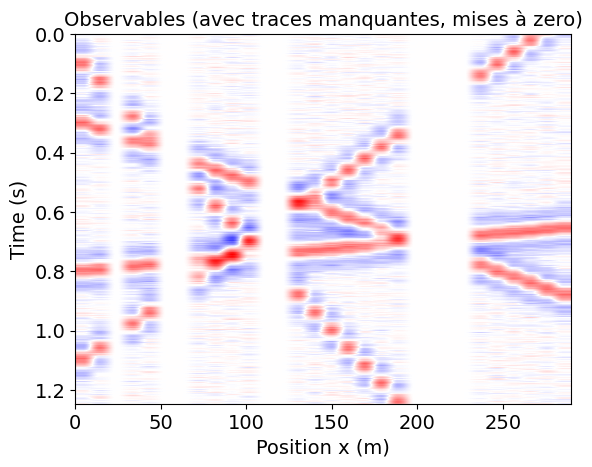

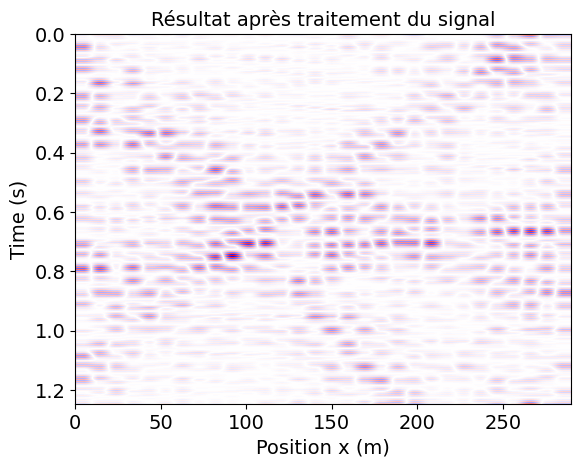

In [92]:
vmax    = np.max(np.abs(gpanel2))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

vmax=np.max(np.abs(np.real(np.fft.ifft2(tf2_m))))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf2_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')

# for p_ in [ 0.002 , -0.004 , -0.0005,0.006]:
#    plt.plot(np.linspace(0,100,500),p_*np.linspace(0,100,500),c='green')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])

# Partie 3. Analyse des limites de l'approche (6 points)
Proposer une nouvelle application sur votre propre jeu de donnees. Vous pouvez par exemple :
* ajouter du bruit sur gpanel1 ou gpanel2
* enlever encore plus de données en entrée (plus de traces blanches) 
* tester sur vos propres données / sur des images récupérées sur internet

Illustrer et discuter une limite (ou plusieurs) que rencontre l'interpolation dans le domaine de Fourier.

**Cette dernière partie est très ouverte et je fais appel à votre créativité.**

On va d'abord essayer de réaliser le même traitement mais en ajoutant du bruit au signal 2.

(400, 30)


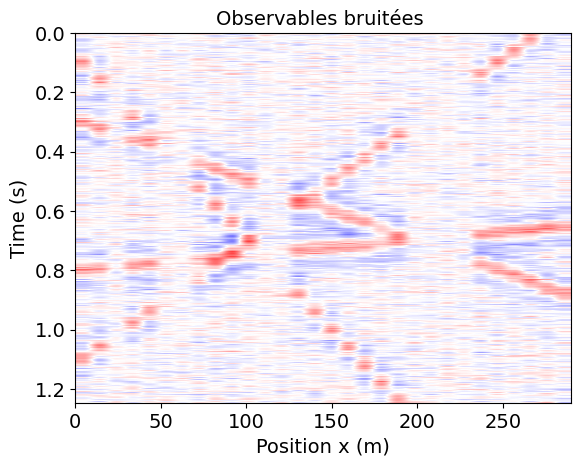

In [99]:
bruit=rd.normal(0,vmax/10,size=gpanel2.shape)
print(bruit.shape)
gpanel_bruit=gpanel2+bruit

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel_bruit,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables bruitées ', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


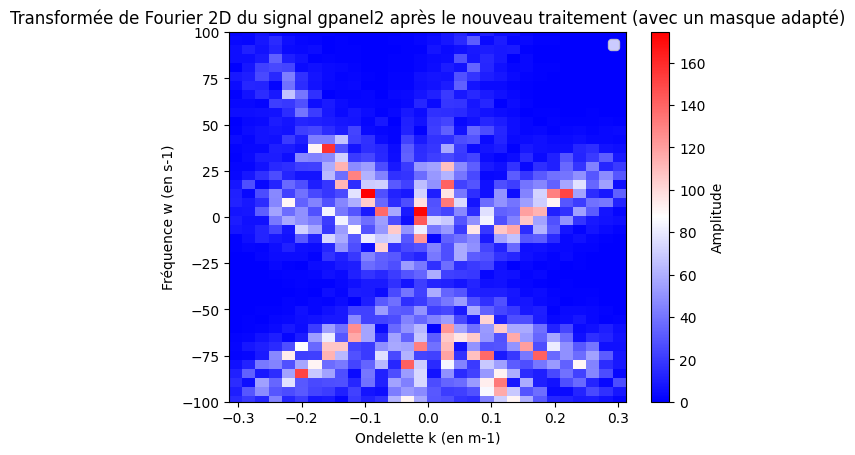

In [118]:
tf3 = np.fft.fftshift(np.fft.fft2(gpanel_bruit))

mask=np.zeros((tf3.shape[0],tf3.shape[1]),dtype=complex)
tf3_m=np.zeros((tf3.shape[0],tf3.shape[1]),dtype=complex)

masque=[]
for p_ in [ 1/0.002 , 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        masque.append([int((k_*p_-min(w))/(max(w)-min(w))*tf3.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf3.shape[1])]) # On identifie l'espace autour des 4 droites 

#distance_tab=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=float)
def distance_au_masque(abscisse,ordonnee): # algorithme NAIF pour déterminer le projecteur 
    dis=float('inf')
    for point in masque: #On itère sur tous les points du masque
        nb_min_atteint=0
        if ((abscisse-point[0])**2+(ordonnee-point[1])**2)<=dis**2:  
            dis=np.sqrt(((abscisse-point[0])**2+(ordonnee-point[1])**2))
            nb_min_atteint+=1
            if ((abscisse-point[0])**2+(ordonnee-point[1])**2)< dis**2: # Si on atteint un nouveau minimum, on fait repartir à 0 le nombre de fois où ce minimum est atteint.
                nb_min_atteint=0
    return [dis,nb_min_atteint]

r=1.9
for i in range(tf3.shape[0]):
    for j in range(tf3.shape[1]):
        mask[i][j]=(r)**(-(distance_au_masque(i,j)[0]+min((distance_au_masque(i,j)[1]-1),0)/sig)) # On calcule la fenêtre autour des 4 droites 

tf3_m=tf3*mask

plt.imshow(np.abs(tf3_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après le nouveau traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

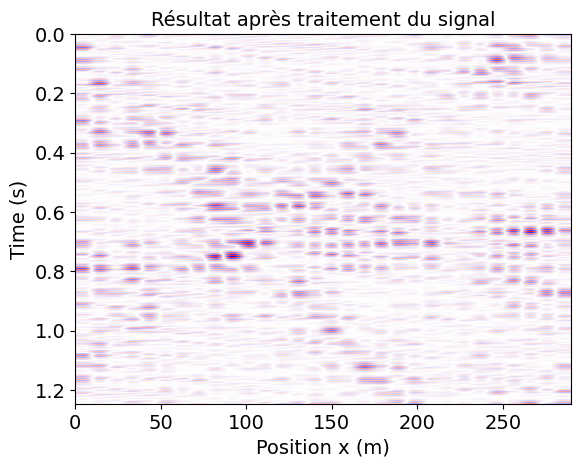

In [120]:
vmax=np.max(np.abs(np.real(np.fft.ifft2(tf3_m))))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf3_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

(400, 30)


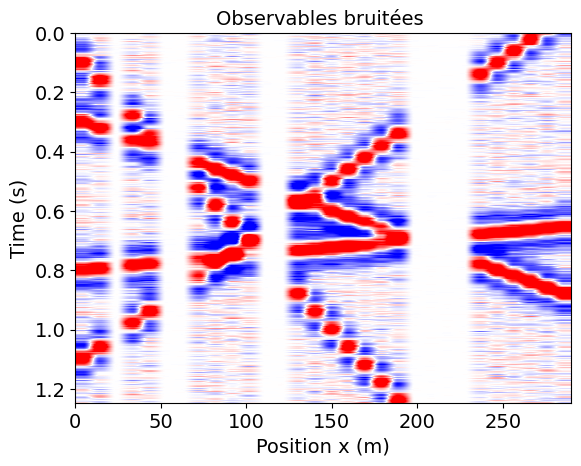

In [122]:
bruit2=np.sin(rd.normal(0,vmax/10,size=gpanel2.shape))*vmax/10  # Le bruit évolue maintenant de façon sinusoïdale
print(bruit2.shape)
gpanel_bruit=gpanel2+bruit2

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel_bruit,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables bruitées ', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


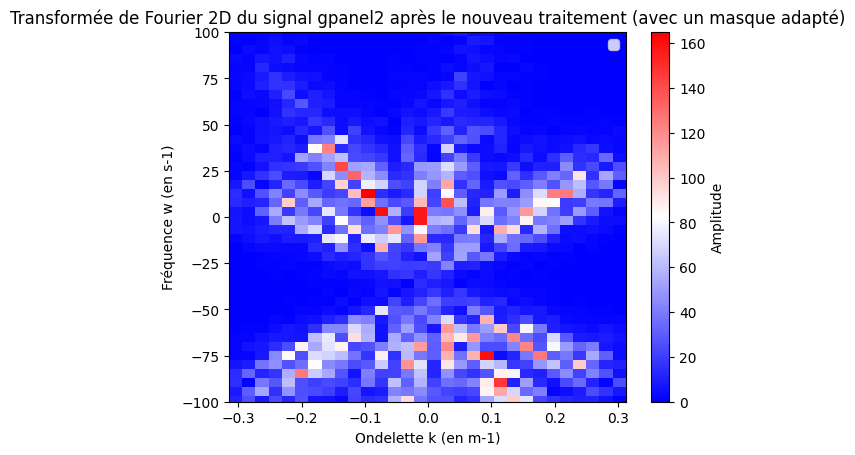

In [123]:
tf3 = np.fft.fftshift(np.fft.fft2(gpanel_bruit))

mask=np.zeros((tf3.shape[0],tf3.shape[1]),dtype=complex)
tf3_m=np.zeros((tf3.shape[0],tf3.shape[1]),dtype=complex)

masque=[]
for p_ in [ 1/0.002 , 1/(-0.004) , 1/(-0.0005),1/0.006]:
    for k_ in np.linspace(-0.25,0.25,100):
        masque.append([int((k_*p_-min(w))/(max(w)-min(w))*tf3.shape[0]),int((k_-min(k))/(max(k)-min(k))*tf3.shape[1])]) # On identifie l'espace autour des 4 droites 

#distance_tab=np.zeros((tf2.shape[0],tf2.shape[1]),dtype=float)
def distance_au_masque(abscisse,ordonnee): # algorithme NAIF pour déterminer le projecteur 
    dis=float('inf')
    for point in masque: #On itère sur tous les points du masque
        nb_min_atteint=0
        if ((abscisse-point[0])**2+(ordonnee-point[1])**2)<=dis**2:  
            dis=np.sqrt(((abscisse-point[0])**2+(ordonnee-point[1])**2))
            nb_min_atteint+=1
            if ((abscisse-point[0])**2+(ordonnee-point[1])**2)< dis**2: # Si on atteint un nouveau minimum, on fait repartir à 0 le nombre de fois où ce minimum est atteint.
                nb_min_atteint=0
    return [dis,nb_min_atteint]

r=1.9
for i in range(tf3.shape[0]):
    for j in range(tf3.shape[1]):
        mask[i][j]=(r)**(-(distance_au_masque(i,j)[0]+min((distance_au_masque(i,j)[1]-1),0)/sig)) # On calcule la fenêtre autour des 4 droites 

tf3_m=tf3*mask

plt.imshow(np.abs(tf3_m), extent=[k2[0], k2[-1], w2[0], w2[-1] ], aspect='auto')
plt.title('Transformée de Fourier 2D du signal gpanel2 après le nouveau traitement (avec un masque adapté)')
plt.xlabel('Ondelette k (en m-1)')
plt.ylabel('Fréquence w (en s-1)')
plt.ylim(-100,100)
plt.colorbar(label='Amplitude')
plt.legend()
plt.show()

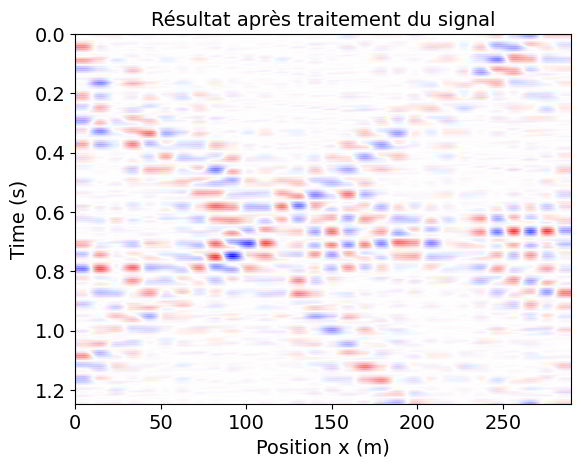

In [124]:
vmax=np.max(np.abs(np.real(np.fft.ifft2(tf3_m))))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(np.real(np.fft.ifft2(tf3_m)),extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Résultat après traitement du signal', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')